In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import os

In [14]:
train_fire_images = []
train_fire_labels = [] 
for directory_path in glob.glob('fire'):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (100, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_fire_images.append(img)
        train_fire_labels.append(fruit_label)
train_fire_images = np.array(train_fire_images)
train_fire_labels = np.array(train_fire_labels)

# plt.imshow(train_fire_images[0])

In [15]:
label_to_id = {v:i for i,v in enumerate(np.unique(train_fire_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_fire_labels])

In [58]:
directory_path

'normal'

In [16]:
train_normal_images = []
train_normal_labels = [] 
for directory_path in glob.glob('normal'):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (100, 100))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_normal_images.append(img)
        train_normal_labels.append(fruit_label)
train_normal_images = np.array(train_normal_images)
train_normal_labels = np.array(train_normal_labels)

In [17]:
label_to_id_normal = {v:i for i,v in enumerate(np.unique(train_normal_labels))}
id_to_label_normal = {v: k for k, v in label_to_id_normal.items()}
train_label_ids_normal = np.array([label_to_id_normal[x] for x in train_normal_labels])
print(id_to_label_normal)

{0: 'normal'}


In [18]:
final_training_labels = np.concatenate((train_fire_labels[:50] , train_normal_labels[:50]))
final_training_images = np.concatenate((train_fire_images[:50] , train_normal_images[:50]))
final_test_labels = np.concatenate((train_fire_labels[50:100] , train_normal_labels[50:100]))
final_test_images = np.concatenate((train_fire_images[50:100] , train_normal_images[50:100]))
final_val_labels = np.concatenate((train_fire_labels[100:110] , train_normal_labels[100:110]))
final_val_images = np.concatenate((train_fire_images[100:110] , train_normal_images[100:110]))



In [19]:
y_train_one_hot = np.reshape( ([1]*int((final_training_labels.shape[0]/2))+[0]*int((final_training_labels.shape[0]/2))) , (-1, 1))    
y_test_one_hot = np.reshape( ([1]*int((final_test_labels.shape[0]/2))+[0]*int((final_test_labels.shape[0]/2))), (-1, 1)) 
y_val_one_hot = np.reshape( ([1]*int((final_val_labels.shape[0]/2))+[0]*int((final_val_labels.shape[0]/2))), (-1, 1)) 


In [20]:
# scale pixels
# convertir integers to floats
train_norm = final_training_images.astype('float32')
test_norm = final_test_images.astype('float32')
val_norm = final_test_images.astype('float32')

# normalizar en rango 0-1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0
val_norm = val_norm / 255.0


In [21]:
def define_model():
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100,100, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))
    # compile modelo
    model.compile(loss='binary_crossentropy', # loss function used for classes that are greater than 2)
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [22]:
model = None
try:
    model = pickle.load(open("cnn_model_2", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Loaded saved model...


In [23]:
import time
stime = time.time()
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

In [24]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = define_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.001)
    
    # filepath='/tmp/weights.hdf5'
    mcp = ModelCheckpoint(os.path.join(os.getcwd(),"best_model_cnn_2.h5"),
                           monitor='accuracy', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)
        
    #csv_logger = CSVLogger( , append=True)
    #csv_logger = CSVLogger(os.path.join('./deep-learning-project/', 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    csv_logger = CSVLogger('training_cnn_2.log', append=True)
    
    
    history = model.fit(train_norm, y_train_one_hot, batch_size=20, epochs= 3,verbose=2, 
                       validation_data=[test_norm,y_test_one_hot], callbacks=[es, mcp, csv_logger])
        
    #history= model.fit(train_norm, y_train_one_hot, 
     #          batch_size=30, epochs=4, validation_split=0.3 )
    
    
    print("saving model...")
    pickle.dump(model, open("cnn_model_2", "wb"))

Building model...
checking if GPU available []
Train on 100 samples, validate on 100 samples
Epoch 1/3
 - 129s - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/3
 - 59s - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/3
 - 55s - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
saving model...


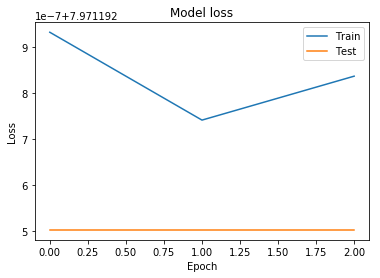

In [25]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [170]:
#model.save('best_cnn.h5')
saved_model = load_model(os.path.join(os.getcwd(), 'best_cnn.h5')) # , "lstm_best_7-3-19_12AM",
saved_model_alex = load_model(os.path.join(os.getcwd(), 'alexnetfruit.h5'))
#print(saved_model)

In [29]:
print(saved_model)

In [31]:
y_pred = model.predict(val_norm)

In [47]:
y_pred_1=  model.predict(val_norm)

In [96]:
import cv2
img_1 = cv2.imread("C:/Users/User/Desktop/nasa/22eqf.jpg", cv2.IMREAD_COLOR)
img_1= cv2.resize(img_1, (100, 100))
img_1= cv2.cvtColor(img_1, cv2.COLOR_RGB2BGR)
img_1_4d= np.expand_dims(img_1, 0)
y_pred_img_1 = saved_model.predict(img_1_4d)

In [174]:
img_ = cv2.imread("C:/Users/User/Desktop/nasa/1.jpg", cv2.IMREAD_COLOR)
img_= cv2.resize(img_, (227, 227))
img_= cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
img_4d= np.expand_dims(img_, 0)
y_pred_img_ = saved_model_alex.predict(img_4d)

In [180]:
y_pred_img_

array([[1.]], dtype=float32)